<h3><b>Installing dependencies</b></h3>

In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 24.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
!pip install -U openai-whisper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.9/792.9 kB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.3 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20230314-py3-none-any.whl size=796926 sha256=730e5c617cd7f781a235f55846da3cf1c4981e8102001998d5efcd98cd617476
  Stored in directory: /root/.cache/pip/wheels/c4/85/e6/0bb9507b8e4f3f6d9c6dcf318bc3514739430375aa8e9eaf5b
Successfully built openai-whisper


In [ ]:
from google.colab import drive 
drive.mount("/content/drive/",force_remount=True)

Mounted at /content/drive/


<h3><b>Data Loading and Preprocessing</b></h3>

In [ ]:
import pandas as pd 
import re
df=pd.read_csv("/content/drive/My Drive/PoetryFoundationData.csv")
df.head()

,Unnamed: 0,Title,Poem,Poet,Tags
0,0,\r\r\n Objects Used to Prop...,"\r\r\nDog bone, stapler,\r\r\ncribbage board, ...",Michelle Menting,NaN
1,1,\r\r\n The New Church\r\r\n...,"\r\r\nThe old cupola glinted above the clouds,...",Lucia Cherciu,NaN
2,2,\r\r\n Look for Me\r\r\n ...,\r\r\nLook for me under the hood\r\r\nof that ...,Ted Kooser,NaN
3,3,\r\r\n Wild Life\r\r\n ...,"\r\r\nBehind the silo, the Mother Rabbit\r\r\n...",Grace Cavalieri,NaN
4,4,\r\r\n Umbrella\r\r\n ...,\r\r\nWhen I push your button\r\r\nyou fly off...,Connie Wanek,NaN


In [ ]:
for i in range(len(df)):
  df.loc[i,"Title"]=str(df.loc[i,"Title"].strip())
  df.loc[i,"Poem"]=str(df.loc[i,"Poem"].strip())
  df.loc[i,"Poem"]=re.sub(r"\r|\n","",str(df.loc[i,"Poem"]))
  df.loc[i,"Poem"]=re.sub("\.|\,|\;","",str(df.loc[i,"Poem"]))

In [ ]:
df=df.drop(columns=["Unnamed: 0","Title","Tags"])

In [ ]:
counts=[]
for i in set(df["Poet"]):
  num=list(df["Poet"]).count(i)
  counts.append([i,num])

In [ ]:
counts.sort(key=lambda f:f[1],reverse=True)

In [ ]:
poets=["William Shakespeare","Alfred, Lord Tennyson","Emily Dickinson","William Wordsworth","William Butler Yeats"]

In [ ]:
d=dict()  
d["Poem"]=[]
d["Poet"]=[]

for i in range(len(df)):
  if df.loc[i,"Poet"] in poets:
    d["Poem"].append(df.loc[i,"Poem"]) 
    d["Poet"].append(df.loc[i,"Poet"])

In [ ]:
new_df=pd.DataFrame(d)

<h3><b>Data Processing to make it compatible for GPT-2 model</b></h3>

In [ ]:
import os
os.mkdir("data/")
os.mkdir("data/train/")
os.mkdir("data/test/")
os.mkdir("data/val/")
os.mkdir("data/live_test/")

In [ ]:
for dt in ["train","test","val","live_test"]:
  for poet in poets: 
    os.mkdir(f"data/{dt}/{poet}/")

In [ ]:
data=new_df[["Poem","Poet"]]

<h3><b>Segmenting the data into Train-Test-Validation</b></h3>

In [ ]:
from sklearn.model_selection import train_test_split 
train_dataset,val_dataset=train_test_split(data,test_size=0.4,random_state=42)
test_dataset,val_dataset=train_test_split(val_dataset,test_size=0.5,random_state=42)
train_dataset.reset_index(drop=True,inplace=True)
test_dataset.reset_index(drop=True,inplace=True)
val_dataset.reset_index(drop=True,inplace=True)

In [ ]:
for dt,nm in [[train_dataset,"train"],[test_dataset,"test"],[val_dataset,"val"]]:
  for i in range(len(dt)):
    poet=dt.loc[i,"Poet"]
    with open(f"data/{nm}/{poet}/{i}.txt","w") as f:
      f.write(dt.loc[i,"Poem"])
    f.close()


<h3><b>Loading Transformers and GPT-2 model</b></h3>

In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 128

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {poets[i]:i for i in range(len(poets))}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)


<b>Model Class</b>

In [ ]:
class PoetryClassifier(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):

    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    self.texts = []
    self.labels = []
    # Since the labels are defined by folders with data we loop 
    # through each label.
    for label in poets:
      sentiment_path = os.path.join(path, label)

      # Get all files from path.
      files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
      # Go through each file and read its content.
      for file_name in tqdm(files_names, desc=f'{label} files'):
        file_path = os.path.join(sentiment_path, file_name)

        # Read content.
        content = io.open(file_path, mode='r', encoding='utf-8').read()
        # Fix any unicode issues.
        content = fix_text(content)
        # Save content.
        self.texts.append(content)
        # Save encode labels.
        self.labels.append(label)

    # Number of exmaples.
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton task. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h3><b>Loading the tokenizer</b></h3>

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)


Loading configuraiton...


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading tokenizer...


Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


<h3><b>Creating Dataloader</b></h3>

In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = PoetryClassifier(path="data/train/", 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  PoetryClassifier(path="data/val/", 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))


Dealing with Train...


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


William Shakespeare files:   0%|          | 0/49 [00:00<?, ?it/s]

Alfred, Lord Tennyson files:   0%|          | 0/46 [00:00<?, ?it/s]

Emily Dickinson files:   0%|          | 0/30 [00:00<?, ?it/s]

William Wordsworth files:   0%|          | 0/31 [00:00<?, ?it/s]

William Butler Yeats files:   0%|          | 0/24 [00:00<?, ?it/s]

Created `train_dataset` with 180 examples!
Created `train_dataloader` with 2 batches!

Dealing with Validation...


William Shakespeare files:   0%|          | 0/18 [00:00<?, ?it/s]

Alfred, Lord Tennyson files:   0%|          | 0/13 [00:00<?, ?it/s]

Emily Dickinson files:   0%|          | 0/11 [00:00<?, ?it/s]

William Wordsworth files:   0%|          | 0/9 [00:00<?, ?it/s]

William Butler Yeats files:   0%|          | 0/10 [00:00<?, ?it/s]

Created `valid_dataset` with 61 examples!
Created `eval_dataloader` with 1 batches!


<h3><b>Initializing hyperparameters and training the model</b></h3>

Epoch


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 4.46276 - val_loss: 4.65056 - train_acc: 0.20556 - valid_acc: 0.16393


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 3.88032 - val_loss: 4.01535 - train_acc: 0.20000 - valid_acc: 0.24590


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 3.17589 - val_loss: 3.47025 - train_acc: 0.26111 - valid_acc: 0.26230


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 2.37629 - val_loss: 3.01105 - train_acc: 0.28333 - valid_acc: 0.27869


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.98884 - val_loss: 2.59479 - train_acc: 0.30556 - valid_acc: 0.36066


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.95107 - val_loss: 2.33724 - train_acc: 0.33333 - valid_acc: 0.34426


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.71364 - val_loss: 2.16720 - train_acc: 0.39444 - valid_acc: 0.40984


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.54231 - val_loss: 2.07773 - train_acc: 0.45000 - valid_acc: 0.39344


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.41202 - val_loss: 2.00168 - train_acc: 0.48333 - valid_acc: 0.36066


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.32539 - val_loss: 1.88206 - train_acc: 0.49444 - valid_acc: 0.32787


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.30922 - val_loss: 1.78361 - train_acc: 0.40556 - valid_acc: 0.31148


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.15957 - val_loss: 1.78112 - train_acc: 0.51667 - valid_acc: 0.29508


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.10230 - val_loss: 1.78086 - train_acc: 0.54444 - valid_acc: 0.31148


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.04329 - val_loss: 1.79927 - train_acc: 0.56667 - valid_acc: 0.34426


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 1.08366 - val_loss: 1.77186 - train_acc: 0.58889 - valid_acc: 0.36066


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.99713 - val_loss: 1.69270 - train_acc: 0.59444 - valid_acc: 0.32787


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.87868 - val_loss: 1.63504 - train_acc: 0.64444 - valid_acc: 0.34426


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.86707 - val_loss: 1.68772 - train_acc: 0.63333 - valid_acc: 0.34426


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.94650 - val_loss: 1.75217 - train_acc: 0.59444 - valid_acc: 0.36066


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.82553 - val_loss: 1.72274 - train_acc: 0.65556 - valid_acc: 0.36066


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.76353 - val_loss: 1.61320 - train_acc: 0.67222 - valid_acc: 0.40984


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.82233 - val_loss: 1.54764 - train_acc: 0.67222 - valid_acc: 0.47541


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.78520 - val_loss: 1.58092 - train_acc: 0.66111 - valid_acc: 0.44262


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.69894 - val_loss: 1.68979 - train_acc: 0.73889 - valid_acc: 0.40984


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.71802 - val_loss: 1.75628 - train_acc: 0.71667 - valid_acc: 0.39344


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.72270 - val_loss: 1.74849 - train_acc: 0.74444 - valid_acc: 0.39344


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.65209 - val_loss: 1.67354 - train_acc: 0.80000 - valid_acc: 0.40984


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.56847 - val_loss: 1.57763 - train_acc: 0.81111 - valid_acc: 0.47541


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.65127 - val_loss: 1.58226 - train_acc: 0.78333 - valid_acc: 0.47541


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.60048 - val_loss: 1.64089 - train_acc: 0.82778 - valid_acc: 0.45902


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.61085 - val_loss: 1.69821 - train_acc: 0.80556 - valid_acc: 0.40984


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.57230 - val_loss: 1.69738 - train_acc: 0.79444 - valid_acc: 0.42623


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.56784 - val_loss: 1.69400 - train_acc: 0.78889 - valid_acc: 0.42623


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.49546 - val_loss: 1.71404 - train_acc: 0.83333 - valid_acc: 0.42623


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.51973 - val_loss: 1.72701 - train_acc: 0.85556 - valid_acc: 0.44262


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.51141 - val_loss: 1.72206 - train_acc: 0.86667 - valid_acc: 0.44262


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.48746 - val_loss: 1.71068 - train_acc: 0.87778 - valid_acc: 0.47541


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.43872 - val_loss: 1.71668 - train_acc: 0.91111 - valid_acc: 0.49180


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.44896 - val_loss: 1.71612 - train_acc: 0.86667 - valid_acc: 0.49180


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.48832 - val_loss: 1.75086 - train_acc: 0.86667 - valid_acc: 0.47541


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.48571 - val_loss: 1.76978 - train_acc: 0.87778 - valid_acc: 0.47541


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.43136 - val_loss: 1.75211 - train_acc: 0.89444 - valid_acc: 0.49180


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.44154 - val_loss: 1.72779 - train_acc: 0.91111 - valid_acc: 0.50820


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.39958 - val_loss: 1.70848 - train_acc: 0.87778 - valid_acc: 0.50820


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.39484 - val_loss: 1.70085 - train_acc: 0.89444 - valid_acc: 0.50820


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.39035 - val_loss: 1.70673 - train_acc: 0.89444 - valid_acc: 0.52459


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.37410 - val_loss: 1.71684 - train_acc: 0.90556 - valid_acc: 0.52459


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.41134 - val_loss: 1.72377 - train_acc: 0.89444 - valid_acc: 0.52459


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.37085 - val_loss: 1.72840 - train_acc: 0.90556 - valid_acc: 0.52459


Training on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1 [00:00<?, ?it/s]

  train_loss: 0.36972 - val_loss: 1.73246 - train_acc: 0.88333 - valid_acc: 0.52459



/usr/local/lib/python3.9/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


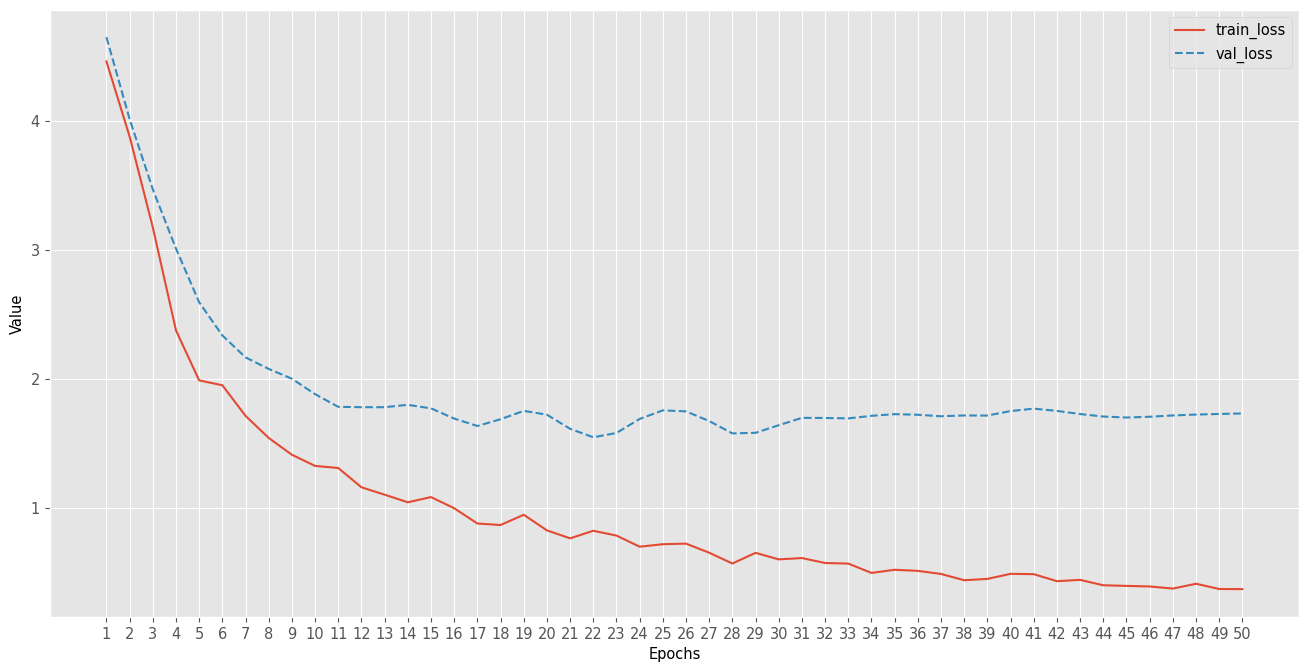

/usr/local/lib/python3.9/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


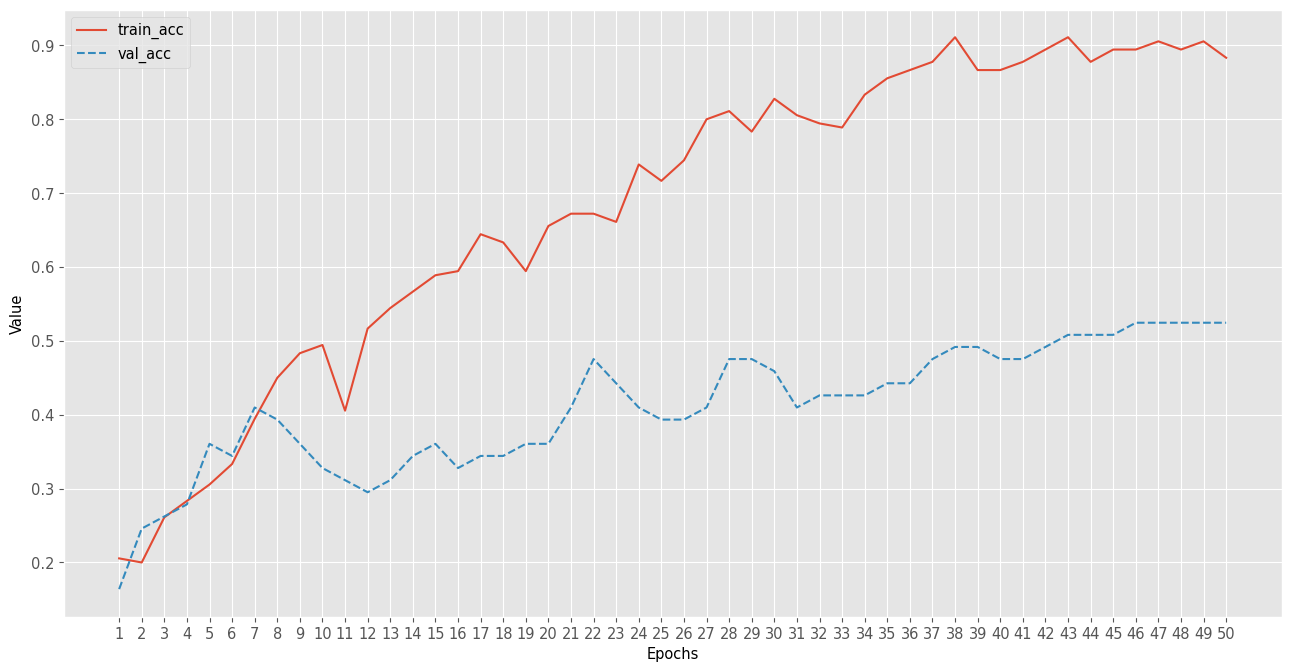

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
epochs=50

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])


<h3><b>testing the results on Validation data</b></h3>

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

  William Shakespeare       0.52      0.67      0.59        18
Alfred, Lord Tennyson       0.55      0.46      0.50        13
      Emily Dickinson       1.00      0.55      0.71        11
   William Wordsworth       0.38      0.89      0.53         9
 William Butler Yeats       0.00      0.00      0.00        10

             accuracy                           0.52        61
            macro avg       0.49      0.51      0.46        61
         weighted avg       0.51      0.52      0.49        61

Normalized confusion matrix


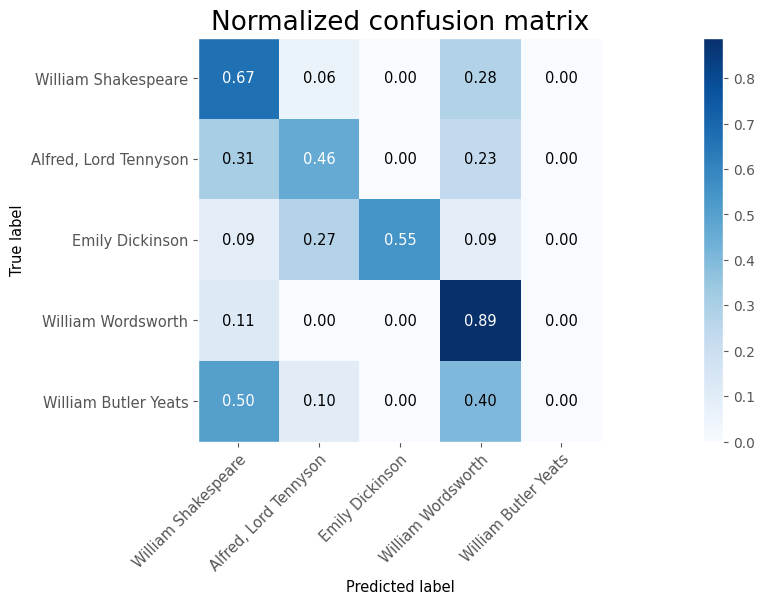

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );


In [ ]:
def test(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer
# Load the saved tokenizer from disk
tokenizer = GPT2Tokenizer.from_pretrained('models/tokenizer')

# Load the saved model from disk
model = GPT2ForSequenceClassification.from_pretrained('models/model')
model.to(device)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h3><b>Converting audio into text for Classification</b></h3>

In [ ]:
import whisper
model_size="small"
whisper_model = whisper.load_model(model_size)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████| 461M/461M [00:02<00:00, 177MiB/s]


In [ ]:
import random
def testing(audio):
  result=whisper_model.transcribe(audio)
  print("Transcribed poem: ",result["text"])
  direc = str(random.choice(poets))
  filename="data/live_test/" + direc + f"/samp_inp_{random.randint(1,1000)}.txt"
  with open(filename,"w") as f:
    f.write(result["text"])
  f.close()
  live_dataset =  PoetryClassifier(path="data/live_test/", 
                               use_tokenizer=tokenizer)

# Move pytorch dataset into dataloader.
  live_dataloader = DataLoader(live_dataset, batch_size=32, shuffle=False, collate_fn=gpt2_classificaiton_collator)
  true_labels, predictions_labels, avg_epoch_loss = test(live_dataloader, device)
  os.remove(filename)
  #for i in range(len(true_labels)):
  #print("True Poet: ",poets[true_labels[0]])

  for i in range(len(predictions_labels)):
    print("This poem was written by ",poets[predictions_labels[i]])


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
answer=testing("/content/drive/MyDrive/aml_presentation/audio/Recording0001_wordsworth.wav")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Transcribed poem:   Surprised by joy, impatient as the wind, I turned to share the transport, O with whom but thee long, buried in the silent tomb, That spot which no vicissitude can find. Love faithful, love recall thee to my mind, But how could I forget thee? Through what power even for the least division of an hour have I been so beguiled as to be blind?


William Shakespeare files:   0%|          | 0/1 [00:00<?, ?it/s]

Alfred, Lord Tennyson files: 0it [00:00, ?it/s]

Emily Dickinson files: 0it [00:00, ?it/s]

William Wordsworth files: 0it [00:00, ?it/s]

William Butler Yeats files: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

This poem was written by  William Wordsworth
